# **Automatic Prediction of MOSFET Threshold Voltage using Machine Learning**

This project implements the approach described in the research paper  
**“Automatic Prediction of MOSFETs Threshold Voltage by Machine Learning Algorithms” (EDTM 2023)**.

The goal is to automatically predict the **threshold voltage** $V_{\text{th}}$ of different MOSFET devices using **machine learning regression models**.  
Traditional $V_{\text{th}}$ extraction methods such as the **Constant Current (CC)**, **Second Derivative**, or **Y–Function** methods can be time-consuming and dependent on researcher interpretation.  
This project replaces that manual process with a **data-driven, objective ML approach**.

----

### **Project Overview**
- **Dataset:** MESD (MOSFET Electrical Simulation Dataset)  
- **Input Features:** Drain current–gate voltage characteristics, i.e., $I_{\text{D}}$–$V_{\text{G}}$ curves  
- **Output Target:** Threshold voltage $V_{\text{th}}$ or its normalized ratio $R_{\text{th}}$  
- **ML Models Used:**  
  - $k$-Nearest Neighbors Regression (kNN)  
  - Decision Tree Regression  
- **Evaluation Metrics:**  
  - Root Mean Square Error (RMSE)  
  - Mean Absolute Error (MAE)  
  - Coefficient of Determination $R^2$

----

### **Objective**
To build a machine learning model that can accurately predict the **threshold voltage** $V_{\text{th}}$ of various MOSFET devices from their $I_{\text{D}}$–$V_{\text{G}}$ characteristics, thereby eliminating subjectivity and improving consistency in device analysis.


In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import glob

In [2]:
!git clone https://github.com/SJTU-YONGFU-RESEARCH-GRP/MESD-MOSFET-Electrical-Simulation-Dataset.git

# !ls MESD-MOSFET-Electrical-Simulation-Dataset/MESD


Cloning into 'MESD-MOSFET-Electrical-Simulation-Dataset'...
Updating files:  36% (18/50)
Updating files:  38% (19/50)
Updating files:  40% (20/50)
Updating files:  42% (21/50)
Updating files:  44% (22/50)
Updating files:  46% (23/50)
Updating files:  48% (24/50)
Updating files:  50% (25/50)
Updating files:  52% (26/50)
Updating files:  54% (27/50)
Updating files:  56% (28/50)
Updating files:  58% (29/50)
Updating files:  60% (30/50)
Updating files:  62% (31/50)
Updating files:  64% (32/50)
Updating files:  66% (33/50)
Updating files:  68% (34/50)
Updating files:  70% (35/50)
Updating files:  72% (36/50)
Updating files:  74% (37/50)
Updating files:  76% (38/50)
Updating files:  78% (39/50)
Updating files:  80% (40/50)
Updating files:  82% (41/50)
Updating files:  84% (42/50)
Updating files:  86% (43/50)
Updating files:  88% (44/50)
Updating files:  90% (45/50)
Updating files:  92% (46/50)
Updating files:  94% (47/50)
Updating files:  96% (48/50)
Updating files:  98% (49/50)
Updating fil

## **Load the Dataset**

This section clones the **MESD (MOSFET Electrical Simulation Dataset)** from GitHub, which contains electrical simulation data for various MOSFET devices.

The dataset includes:
- Multiple device types (nMOS, pMOS, FinFET, etc.)
- Different PDKs (Process Design Kits)
- I–V characteristics, i.e., $V_{\text{GS}}$–$I_{\text{D}}$ curves
- Device metadata (temperature, dimensions, etc.)


In [3]:
def load_mesd_data():
  data_folder_path = 'MESD-MOSFET-Electrical-Simulation-Dataset/MESD'
  json_files = glob.glob(os.path.join(data_folder_path, "*.json"))
  json_files.sort()
  all_data = []
  for file_path in json_files:
    file_name = os.path.basename(file_path)
    if file_name == "N180A-pmos1.json": # Faulty data file
      print(f"Skipping: {file_name}")
      continue
    with open(file_path, 'r') as f:
      data = json.load(f)
      all_data.append(data)
  return all_data

mesd_data = load_mesd_data()
print(f"Loaded {len(mesd_data)} JSON files")

Skipping: N180A-pmos1.json
Loaded 43 JSON files


## **Threshold Voltage Extraction Methods**

This function implements three different methods to extract the threshold voltage ($V_{th}$) from I-V curves:

### Method 1: Second Derivative (Default)
Finds the peak of the second derivative of $\log_{10}(I_D)$ with respect to $V_{GS}$:

$$\frac{d^2(\log_{10} I_D)}{dV_{GS}^2}$$

### Method 2: Constant Current
Finds $V_{GS}$ at a predefined current level (e.g., $10^{-7}$ A)

### Method 3: Y-Function
Extrapolates the linear region of the Y-function to find the x-intercept

In [4]:
def extract_threshold_voltage(vgs, ids, method='2nd_derivative'):
  if method == '2nd_derivative':
      # Calculate 2nd derivative of log(Ids) w.r.t Vgs
      log_ids = np.log10(np.abs(ids) + 1e-15) 
      first_deriv = np.gradient(log_ids, vgs)
      second_deriv = np.gradient(first_deriv, vgs)

      # Find peak of 2nd derivative
      peak_idx = np.argmax(second_deriv)
      return vgs[peak_idx]

  elif method == 'constant_current':
      # Find Vgs at predefined current level
      target_current = 1e-7
      idx = np.argmin(np.abs(ids - target_current))
      return vgs[idx]

  elif method == 'y_function':
      y_func = ids / np.sqrt(np.abs(ids) + 1e-15)
      linear_region = y_func[len(y_func)//2:]
      vgs_linear = vgs[len(vgs)//2:]
      
      coeffs = np.polyfit(vgs_linear, linear_region, 1)
      vth = -coeffs[1] / coeffs[0] 
      return vth

## **Calculate Threshold Ratio ($R_{\text{th}}$)**

This function normalizes the threshold voltage to a ratio between 0 and 1 based on the $V_{\text{GS}}$ range.

**Formula:**

$$
R_{\text{th}} = \frac{V_{\text{th}} - V_{G,\text{min}}}{V_{G,\text{max}} - V_{G,\text{min}}}
$$

**Purpose:**
- Normalizes $V_{\text{th}}$ to a dimensionless value (0 to 1)
- Makes the target variable independent of the specific voltage range
- Improves ML model generalization across different device types
- Acts as the target variable (label) for supervised learning


In [5]:
def calculate_threshold_ratio(vgs, vth):
  vg_min, vg_max = min(vgs), max(vgs)
  rth = (vth - vg_min) / (vg_max - vg_min)
  return rth

## **Preprocess MESD Data for ML Training**

This function processes raw MESD dataset records into a structured format suitable for machine learning.

**Key Steps:**
1. **Extract device metadata** (Type, PDK) from each file
2. **Extract $V_{\text{th}}$** using the specified method (2nd derivative by default)
3. **Normalize I–V curves**:
   - $V_{\text{GS}}$ normalization: $\frac{V_{\text{GS}} - V_{G,\text{min}}}{V_{G,\text{max}} - V_{G,\text{min}}}$
   - $I_{\text{DS}}$ normalization: $\frac{I_{\text{DS}} - I_{\text{DS,min}}}{I_{\text{DS,max}} - I_{\text{DS,min}}}$
4. **Calculate threshold ratio ($R_{\text{th}}$)**
5. **Create feature vectors** from normalized $I_{\text{DS}}$ values

**Output:** List of dictionaries containing:
- `features`: Normalized I–V curve (array)
- `rth`: Threshold ratio target value ($R_{\text{th}}$)
- `metadata`: Device information
- `vgs_range`: $(V_{G,\text{min}}, V_{G,\text{max}})$ for inverse transformation


In [6]:
def preprocess_mesd_data(mesd_data, extraction_method='2nd_derivative'):
  VG_NORMALIZED_AXIS_50 = np.linspace(0, 1, 50)
  MIN_ON_CURRENT = 1e-7


  processed_data = []

  for device_data in mesd_data:
      device_type = device_data['Type']
      pdk = device_data['PDK']

      for record in device_data['Records']:

          vgs = np.array(record['Vgs'])
          ids = np.array(record['Ids'])

          # Filter out the data whose Corner is not "tt" (Typical-Typical)
          if (record.get('Corner') != "tt"):
            continue

          try:

              log_ids = np.log10(np.abs(ids)+ 1e-15)
              # Normalize VG and interpolate Ids
              vgs_norm = (vgs - vgs.min()) / (vgs.max() - vgs.min())
              sort_indices = np.argsort(vgs_norm)
              vgs_norm_sorted = vgs_norm[sort_indices]
              log_ids_sorted = log_ids[sort_indices]
              vgs_resampled = np.interp(VG_NORMALIZED_AXIS_50, vgs_norm_sorted, vgs[sort_indices])
              ids_resampled = np.interp(VG_NORMALIZED_AXIS_50, vgs_norm_sorted, ids[sort_indices])

              vth = extract_threshold_voltage(vgs_resampled, ids_resampled, extraction_method)
              rth = calculate_threshold_ratio(vgs_resampled, vth)

              log_ids_resampled = np.interp(VG_NORMALIZED_AXIS_50, vgs_norm_sorted, log_ids_sorted)

              min_log_id = log_ids_resampled.min()
              max_log_id = log_ids_resampled.max()

              # Filtering out flat lines
              if np.isclose(max_log_id, min_log_id):
                  continue

              # Create feature vector with normalized Ids values
              ids_norm = (log_ids_resampled - min_log_id) / (max_log_id - min_log_id)
              features = ids_norm

              processed_data.append({
                  'features': features,
                  'rth': rth,
                  'vth' : vth,
                  'device_type': device_type,
                  'pdk': pdk,
                  'vgs_range': (vgs.min(), vgs.max()),
                  'metadata': {
                      'temp': record.get('Temp', 25),
                      'vds': record.get('Vds', 0),
                      'w': record.get('W', 0),
                      'l': record.get('L', 0),
                      'nfin': record.get('Nfin', 1)
                  }
              })
          except Exception as e:
              print(f"Error processing record: {e}")
              continue

  return processed_data

processed_data = preprocess_mesd_data(mesd_data, extraction_method='2nd_derivative')


## **Create Feature Matrix with Consistent Dimensions**

This function prepares the processed data for ML by creating consistent-length feature vectors.

**Process:**
- Determines maximum feature length across all samples
- Pads shorter sequences with zeros to match max_length
- Truncates longer sequences to max_length
- Returns numpy arrays for X (features) and y (targets)


In [7]:
def create_feature_matrix(processed_data):
  X = []
  y = []
  metadata = []

  for data in processed_data:
      features = data['features']
      X.append(features)
      y.append(data['rth'])
      metadata.append(data['metadata'])

  return np.array(X), np.array(y), metadata

# Process the data
X, y, metadata = create_feature_matrix(processed_data)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (102800, 50)
Target vector shape: (102800,)


## **Train Machine Learning Models**

This function trains multiple **machine learning regression models** — k-Nearest Neighbors (kNN) and Decision Tree Regressor — to predict the threshold ratio ($R_{th}$).

### **Workflow**
1. **Data Splitting:**
   - The dataset $(X, y)$ is split into training and testing sets using `train_test_split`.
   - Typical split ratio: 70% training and 30% testing.

2. **Models Used:**
   - **kNN Regressor**: Non-parametric model based on feature similarity.
   - **Decision Tree Regressor**: Learns hierarchical feature-based rules.

3. **Training and Evaluation:**
   - Each model is trained on the training set.
   - Predictions are made on the test set.
   - Evaluation metrics are computed:
     - Root Mean Squared Error (RMSE)
     - Mean Absolute Error (MAE)
     - Coefficient of Determination ($R^2$)

### **Mathematical Metrics**

- **Root Mean Squared Error (RMSE):**
  $$
  RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
  $$

- **Mean Absolute Error (MAE):**
  $$
  MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
  $$

- **Coefficient of Determination ($R^2$):**
  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
  $$

### **Purpose**
- Evaluate performance of different ML algorithms.
- Identify which model best predicts the normalized threshold ratio ($R_{th}$).
- Serve as a baseline for more advanced regression methods (e.g., SVR, Random Forest, or Neural Networks).


In [8]:
def train_ml_models(X, y, test_size=0.3, random_state=42):

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_size, random_state=random_state
  )

  models = {
      'kNN': KNeighborsRegressor(n_neighbors=5),
      'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=random_state)
  }

  results = {}

  for name, model in models.items():
      print(f"\nTraining {name}...")

      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # Error Metrics
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mae = mean_absolute_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)

      results[name] = {
          'model': model,
          'rmse': rmse,
          'mae': mae,
          'r2': r2,
          'predictions': y_pred,
          'actual': y_test
      }

      print(f"{name} Results:")
      print(f"  RMSE: {rmse:.4f}")
      print(f"  MAE: {mae:.4f}")
      print(f"  R²: {r2:.4f}")

  return results, X_train, X_test, y_train, y_test

results, X_train, X_test, y_train, y_test = train_ml_models(X, y)



Training kNN...
kNN Results:
  RMSE: 0.0210
  MAE: 0.0042
  R²: 0.9972

Training Decision Tree...
Decision Tree Results:
  RMSE: 0.0331
  MAE: 0.0140
  R²: 0.9930


## **Plot Actual vs Predicted Values**

This function visualizes the performance of trained machine learning models by plotting **actual vs. predicted values** of the normalized threshold ratio ($R_{th}$).

---

### **Function Purpose**

- Compare model predictions with ground truth.
- Assess accuracy and generalization visually.
- Identify systematic under- or over-prediction.

---

### **Workflow**

1. **Scatter Plot of Actual vs Predicted:**
   - Each point represents a single test sample $(R_{th}^{actual}, R_{th}^{predicted})$.
   - Ideal predictions lie on the **diagonal line**:
     $$
     R_{th}^{predicted} = R_{th}^{actual}
     $$

2. **Line of Perfect Prediction:**
   - Red dashed line indicates $y = x$.
   - Deviations from this line show the prediction error.

3. **Additional Plot Features:**
   - Grid with dashed lines for readability.
   - Equal aspect ratio ensures diagonal line is 45°.
   - Legend shows $R^2$ for each model.



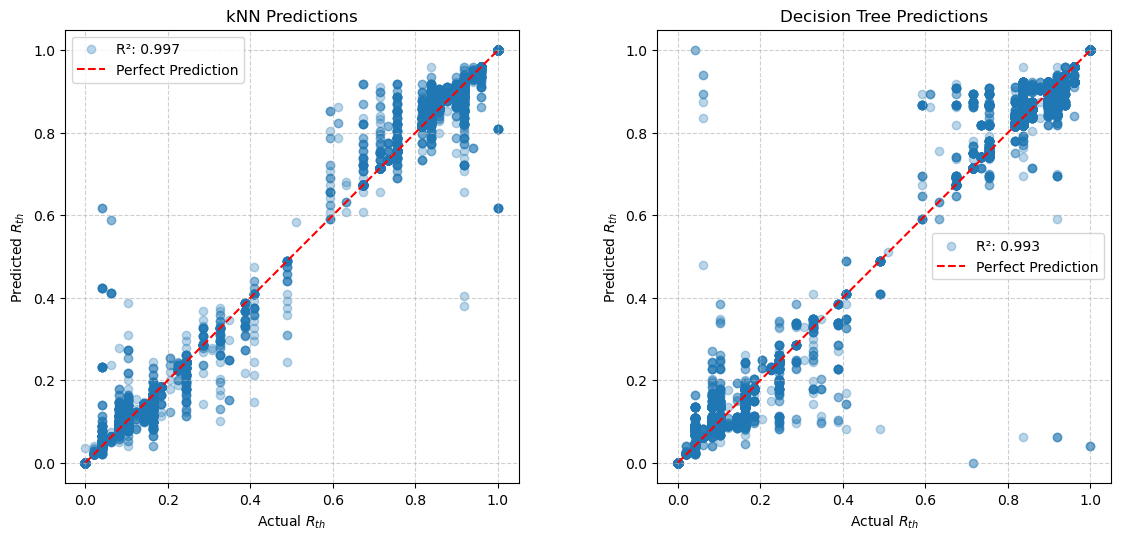

In [9]:
def plot_predictions(results):

    num_models = len(results)
    if num_models == 0:
        print("No results to plot.")
        return

    fig, axs = plt.subplots(1, num_models, figsize=(6 * num_models, 5.5), squeeze=False)
    axs = axs.flatten()

    for i, (name, res) in enumerate(results.items()):
        y_test = res['actual']
        y_pred = res['predictions']

        axs[i].scatter(y_test, y_pred, alpha=0.3, label=f'R²: {res["r2"]:.3f}')
        # Line of perfect prediction (y=x)
        min_val = min(np.min(y_test), np.min(y_pred))
        max_val = max(np.max(y_test), np.max(y_pred))
        axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        axs[i].set_title(f"{name} Predictions")
        axs[i].set_xlabel("Actual $R_{th}$")
        axs[i].set_ylabel("Predicted $R_{th}$")
        axs[i].legend()
        axs[i].grid(True, ls='--', alpha=0.6)
        axs[i].set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()
plot_predictions(results)

## **Predict Threshold Voltage ($V_{th}$) from Normalized Ratio ($R_{th}$)**

This function uses a trained machine learning model to predict the **threshold voltage** ($V_{th}$) of a device from its normalized I–V features.

---

### **Function Purpose**

- Predict the normalized threshold ratio $R_{th}$ using the model.
- Convert $R_{th}$ back to the **actual threshold voltage** $V_{th}$ based on the $V_{GS}$ sweep range.
- Optionally uses device metadata for further processing (not required for prediction).

---

### **Workflow**

1. **Predict $R_{th}$:**
   - The normalized feature vector `ids_normalized` is fed into the trained model:

$$
\hat{R}_{\text{th}} = f_{\text{model}}(X)
$$

2. **Convert Back to Actual Threshold Voltage:**
   - Given the gate voltage sweep range $(V_{G,\min}, V_{G,\max})$, compute:

$$
V_{\text{th}} = \hat{R}_{\text{th}} \cdot (V_{G,\max} - V_{G,\min}) + V_{G,\min}
$$




In [10]:
def predict_threshold_voltage(model, vgs_range, ids_normalized, device_metadata=None):

    rth_pred = model.predict(ids_normalized.reshape(1, -1))[0]

    # Convert back to actual threshold voltage
    vg_min, vg_max = vgs_range
    vth_pred = rth_pred * (vg_max - vg_min) + vg_min

    return vth_pred, rth_pred

## **Validate Threshold Voltage Predictions**

This code evaluates the **accuracy of the trained model** on a subset of devices by comparing the predicted threshold voltage ($V_{th}$) with the true values.



In [12]:
import random
best_model = results['kNN']['model']  # Use best performing model

VTH_TOLERANCE = 1e-3  # 0.001 V
validation_set = random.sample(processed_data, k=100)

match_count = 0
for sample_device in validation_set:
  vth_pred, rth_pred = predict_threshold_voltage(
      best_model,
      sample_device['vgs_range'],
      sample_device['features']
    )
  vth_true = sample_device.get('vth')
  if vth_true is not None and np.isclose(vth_pred, vth_true, atol=VTH_TOLERANCE):
  # if vth_true == vth_pred:
      match_count += 1

print(f"Number of accurate predictions within {VTH_TOLERANCE} V:", match_count)

Number of accurate predictions within 0.001 V: 87
